# Human Evaluation

In this notebook we focus on parsing, aggregating and forming useful insights on the human evaluation output.

In [54]:
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
sns.set_palette("deep")

In [5]:
EVALUATED_PATH = "../storage/results/human_evaluation/cordis/out/curated_no_injection_cordis_with_query_t5_small_full_totto.json"

with open(EVALUATED_PATH) as f:
    evaluations = json.load(f)

## Count per category

In [6]:
evaluation_choices = [evaluation['evaluation'].split(',') for evaluation in evaluations]
flattened_choices = [flattened_evaluation for evaluation in evaluation_choices for flattened_evaluation in evaluation]

summed_choices = Counter(flattened_choices)
print(summed_choices)

percentage_choices = {key: val / len(evaluation_choices) for key, val in summed_choices.items()}
print(percentage_choices)

Counter({'Omission': 38, 'Erroneous': 32, 'Correct': 10, 'Hallucination': 3})
{'Omission': 0.6785714285714286, 'Erroneous': 0.5714285714285714, 'Correct': 0.17857142857142858, 'Hallucination': 0.05357142857142857}


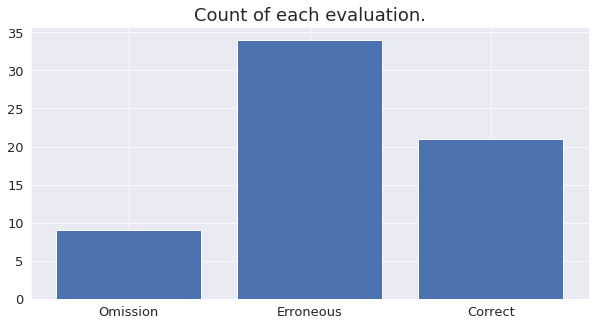

In [5]:
plt.figure(figsize=(10,5))

plt.bar(summed_choices.keys(), summed_choices.values())
plt.title("Count of each evaluation.")
plt.show()

## Inference examples

In [ ]:
category = "Erroneous"

for evaluation in evaluations:
    if category in evaluation['evaluation']:
        print("-"*100)
        print(f"Target: {evaluation['target']}\n")
        print(f"Predicted: {evaluation['predicted']}\n")
        print(f"Source: {evaluation['source']}\n")
        print("-"*100)

## Detailed Human Evaluation

### Reading the files

In [38]:
evaluations_dir = 'storage/results/human_evaluation/qr2t/evaluated/07_29_2022__14_01_44'

all_annotations = []
for file in glob.glob(f"../{evaluations_dir}/*.json"):
    with open(file) as f:
        evaluations = json.load(f)
    annotator = file.split('/')[-1][:-5]

    for evaluation in evaluations:
        eval_choices = evaluation['annotations'][0]['result']
        
        def find_ind_of_attribute(attribute):
            for ind, val in enumerate(eval_choices):
                if val['from_name'] == attribute:
                    return ind
            return -1
        
        try:
            eval_info = [
                evaluation['data']['id'],
                evaluation['data']['model'],
                annotator,
                eval_choices[find_ind_of_attribute('correctness')]['value']['choices'][0],
                eval_choices[find_ind_of_attribute('fluency')]['value']['choices'][0],
                eval_choices[find_ind_of_attribute('syntax_errors')]['value']['number'],
                eval_choices[find_ind_of_attribute('value_usage_error')]['value']['number'],
                eval_choices[find_ind_of_attribute('omisions')]['value']['number'],
                eval_choices[find_ind_of_attribute('altered_values')]['value']['number'],
                eval_choices[find_ind_of_attribute('added_attributes')]['value']['number'],
                eval_choices[find_ind_of_attribute('other')]['value']['number'],
                eval_choices[find_ind_of_attribute('comment')]['value']['text'][0] if find_ind_of_attribute('comment') != -1 else ""            
            ]
        except KeyError:
            print(annotator, evaluation)
            
        all_annotations.append(eval_info)

In [43]:
eval_df = pd.DataFrame(all_annotations, columns=['id', 'model', 'annotator', 'correctness', 
                                                 'fluency', 'syntax_errors', 'value_usage_error', 
                                                 'omisions', 'altered_values', 'added_attributes',
                                                 'other', 'comment'])

display(eval_df)

,id,model,annotator,correctness,fluency,syntax_errors,value_usage_error,omisions,altered_values,added_attributes,other,comment
0,8,totto_qr2t,Anna,Correct,Adequate,0,0,0,0,0,0,
1,98,aux_totto_qr2t,Anna,Correct,Not fluent,0,0,0,0,0,0,
2,128,pre_totto_qr2t,Anna,Incorrect,Perfect,0,1,0,0,1,0,
3,296,pre_totto_qr2t,Anna,Incorrect,Not fluent,1,3,0,0,0,0,
4,307,aux_totto_qr2t,Anna,Correct,Perfect,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
344,95,qr2t,Katerina,Correct,Perfect,0,0,0,0,0,0,
345,148,totto_qr2t,Katerina,Correct,Perfect,0,0,0,0,0,0,
346,8,aux_totto_qr2t,Katerina,Incorrect,Perfect,0,0,0,1,0,0,
347,218,qr2t,Katerina,Correct,Perfect,0,0,0,0,0,0,


### Correctness of each model

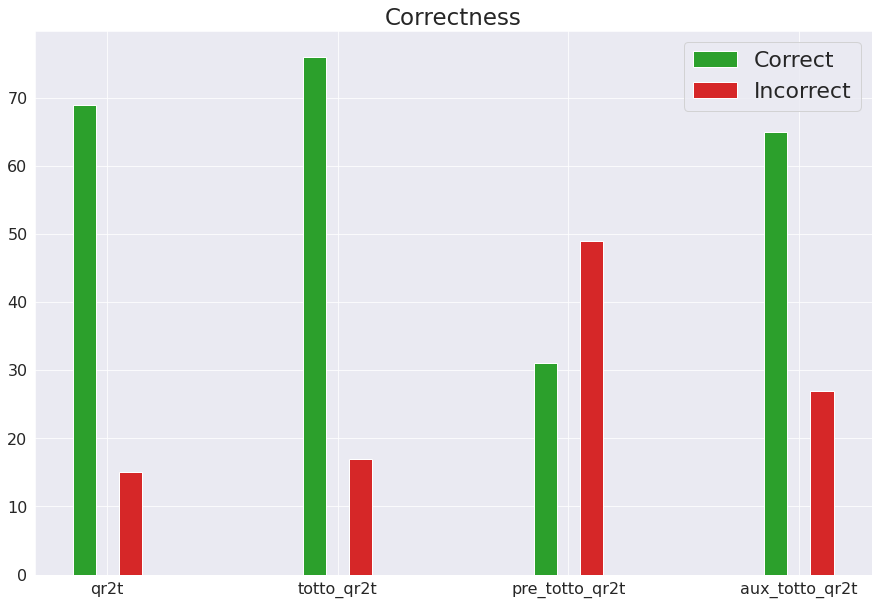

In [83]:
def get_number_of_correct_wrong(model_name, eval_df):
    df_model = eval_df.loc[eval_df['model'] == model_name]
    
    return len(df_model.loc[df_model['correctness'] == 'Correct']), len(df_model.loc[df_model['correctness'] == 'Incorrect'])


fig, ax = plt.subplots(figsize=(15,10))

models = ['qr2t', 'totto_qr2t', 'pre_totto_qr2t', 'aux_totto_qr2t']
current_step = 1

for model_name in models:
    correct, wrong = get_number_of_correct_wrong(model_name, eval_df)


    plt.bar([current_step], [correct], width=0.1, color='tab:green', label="Correct" if model_name == 'qr2t' else None)
    plt.bar([current_step + 0.2], [wrong], width=0.1, color='tab:red', label="Incorrect" if model_name == 'qr2t' else None)

    current_step += 1

plt.xticks(np.arange(1.1, 5.1), fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(models)

plt.legend(fontsize=22)
plt.title('Correctness', fontsize=23)

plt.show()

### Flunecy of each model

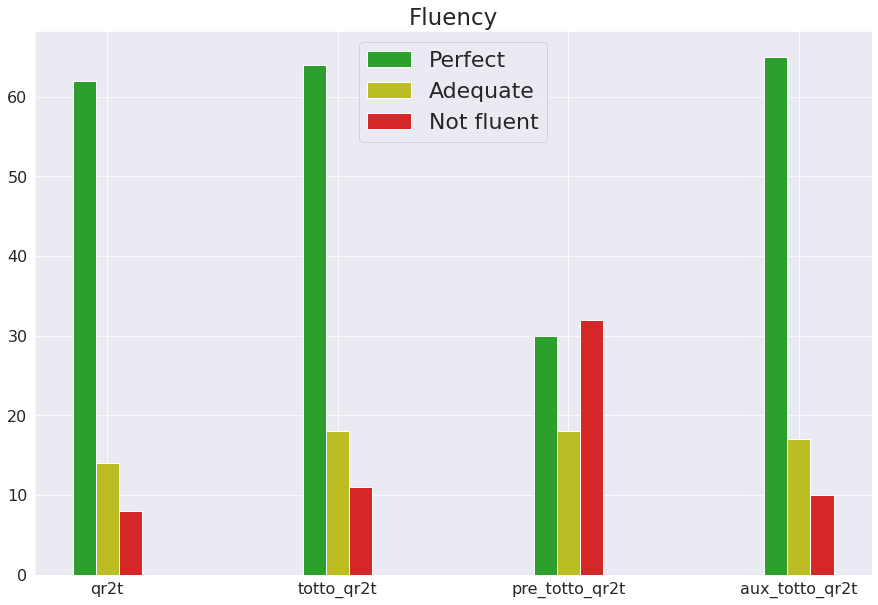

In [80]:
def get_number_of_perfect_adequate_bad(model_name, eval_df):
    df_model = eval_df.loc[eval_df['model'] == model_name]
    
    return len(df_model.loc[df_model['fluency'] == 'Perfect']), len(df_model.loc[df_model['fluency'] == 'Adequate']), len(df_model.loc[df_model['fluency'] == 'Not fluent'])


fig, ax = plt.subplots(figsize=(15,10))

models = ['qr2t', 'totto_qr2t', 'pre_totto_qr2t', 'aux_totto_qr2t']
current_step = 1

for model_name in models:
    perfect, adequate, not_fluent = get_number_of_perfect_adequate_bad(model_name, eval_df)

    plt.bar([current_step], [perfect], width=0.1, color='tab:green', label="Perfect" if model_name == 'qr2t' else None)
    plt.bar([current_step + 0.1], [adequate], width=0.1, color='tab:olive', label="Adequate" if model_name == 'qr2t' else None)
    plt.bar([current_step + 0.2], [not_fluent], width=0.1, color='tab:red', label="Not fluent" if model_name == 'qr2t' else None)

    current_step += 1

plt.xticks(np.arange(1.1, 5.1), fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(models)

plt.legend(fontsize=22)
plt.title('Fluency', fontsize=23)

plt.show()

### Winnning Model

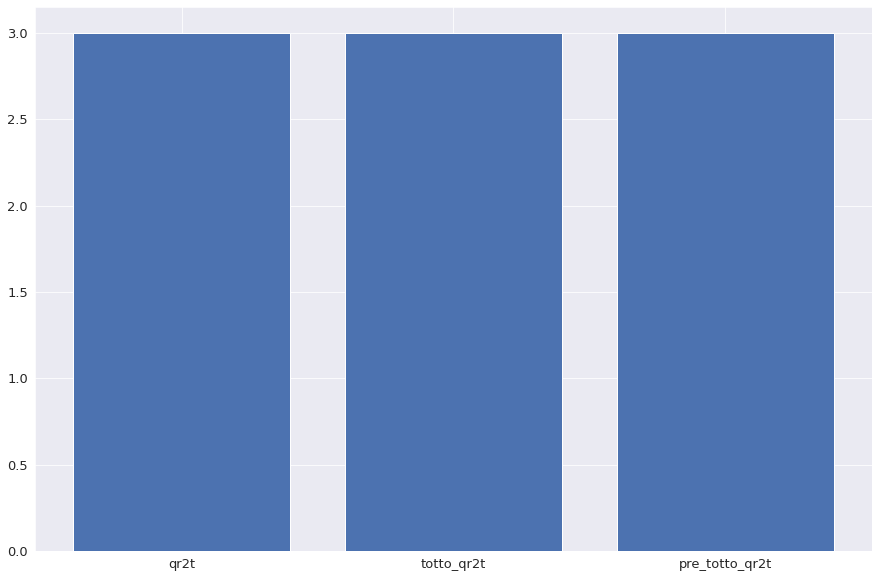

In [114]:
dfs_per_model = {
    'qr2t': eval_df.loc[eval_df['model'] == 'qr2t'],
    'totto_qr2t': eval_df.loc[eval_df['model'] == 'totto_qr2t'],
    'pre_totto_qr2t': eval_df.loc[eval_df['model'] == 'pre_totto_qr2t'],
    'aux_totto_qr2t': eval_df.loc[eval_df['model'] == 'aux_totto_qr2t'],
}

dfs_correctness_per_model = { key: df.filter(['id', 'correctness']).rename(columns={'correctness': f'{key}'}) for key, df in dfs_per_model.items()}

dfs_correctness_per_model['qr2t']

df_outer = pd.merge(dfs_correctness_per_model['qr2t'], dfs_correctness_per_model['totto_qr2t'], on='id', how='inner')
df_outer = pd.merge(df_outer, dfs_correctness_per_model['pre_totto_qr2t'], on='id', how='inner')
df_outer = pd.merge(df_outer, dfs_correctness_per_model['aux_totto_qr2t'], on='id', how='inner').drop(['id'], axis=1)

df_outer = df_outer.replace(['Correct', 'Incorrect'], [1, 0])
wins = np.sum(df_outer, axis=0)


fig, ax = plt.subplots(figsize=(15,10))
plt.bar(wins.index, wins)
plt.show()